In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('./csv/preprocessed_data.csv')
df.head()

,Group,Rt_scale_IKI-mean,Rt_scale_IKI-SD,Rt_scale_IRI-mean,Rt_scale_IRI-SD,Rt_long_scale_IKI-mean,Rt_long_scale_IKI-SD,Rt_long_scale_IRI-mean,Rt_long_scale_IRI-SD,Rt_arpeggio_IKI-mean,...,Lt_long_scale_IKI-mean,Lt_long_scale_IKI-SD,Lt_long_scale_IRI-mean,Lt_long_scale_IRI-SD,Lt_arpeggio_IKI-mean,Lt_arpeggio_IKI-SD,Lt_arpeggio_IRI-mean,Lt_arpeggio_IRI-SD,handedness,affected side
0,1,82.312112,13.229921,82.135133,28.898811,86.265478,13.311980,86.875652,39.062791,90.066294,...,95.666406,13.465412,96.125029,39.938112,101.131731,16.358171,102.647460,40.739545,R,NaN
1,1,88.946394,12.973927,89.013980,31.402664,98.032472,12.947017,105.671697,54.441392,118.003340,...,104.111900,14.654740,111.136122,58.183404,168.127512,16.548132,168.258340,27.776093,R,NaN
2,1,69.061144,13.557577,71.281947,28.322600,90.262109,11.066986,90.212710,25.212559,83.783431,...,96.978944,11.653787,96.649603,29.018465,97.928150,21.112888,98.374447,47.075235,R,NaN
3,1,104.627531,14.773290,103.568700,30.408687,128.489531,16.464423,127.964277,35.699352,150.809331,...,161.587047,17.913393,161.105616,40.423535,180.687931,16.687300,180.634780,35.095249,R,NaN
4,1,88.024163,15.166748,89.525860,22.041914,97.867809,12.792190,97.921832,30.024507,214.103394,...,114.973956,12.947909,114.820481,37.861518,224.061081,12.329798,224.257727,18.891626,R,NaN


In [15]:
# 全ての演奏関連特徴量の多重共線性チェック
performance_features = [
    # 右手の特徴量（平均値のみ）
    'Rt_scale_IKI-mean', 'Rt_long_scale_IKI-mean', 'Rt_arpeggio_IKI-mean',
    'Rt_scale_IRI-mean', 'Rt_long_scale_IRI-mean', 'Rt_arpeggio_IRI-mean',
    # 左手の特徴量（平均値のみ）
    'Lt_scale_IKI-mean', 'Lt_long_scale_IKI-mean', 'Lt_arpeggio_IKI-mean',
    'Lt_scale_IRI-mean', 'Lt_long_scale_IRI-mean', 'Lt_arpeggio_IRI-mean'
]

X = df[performance_features]

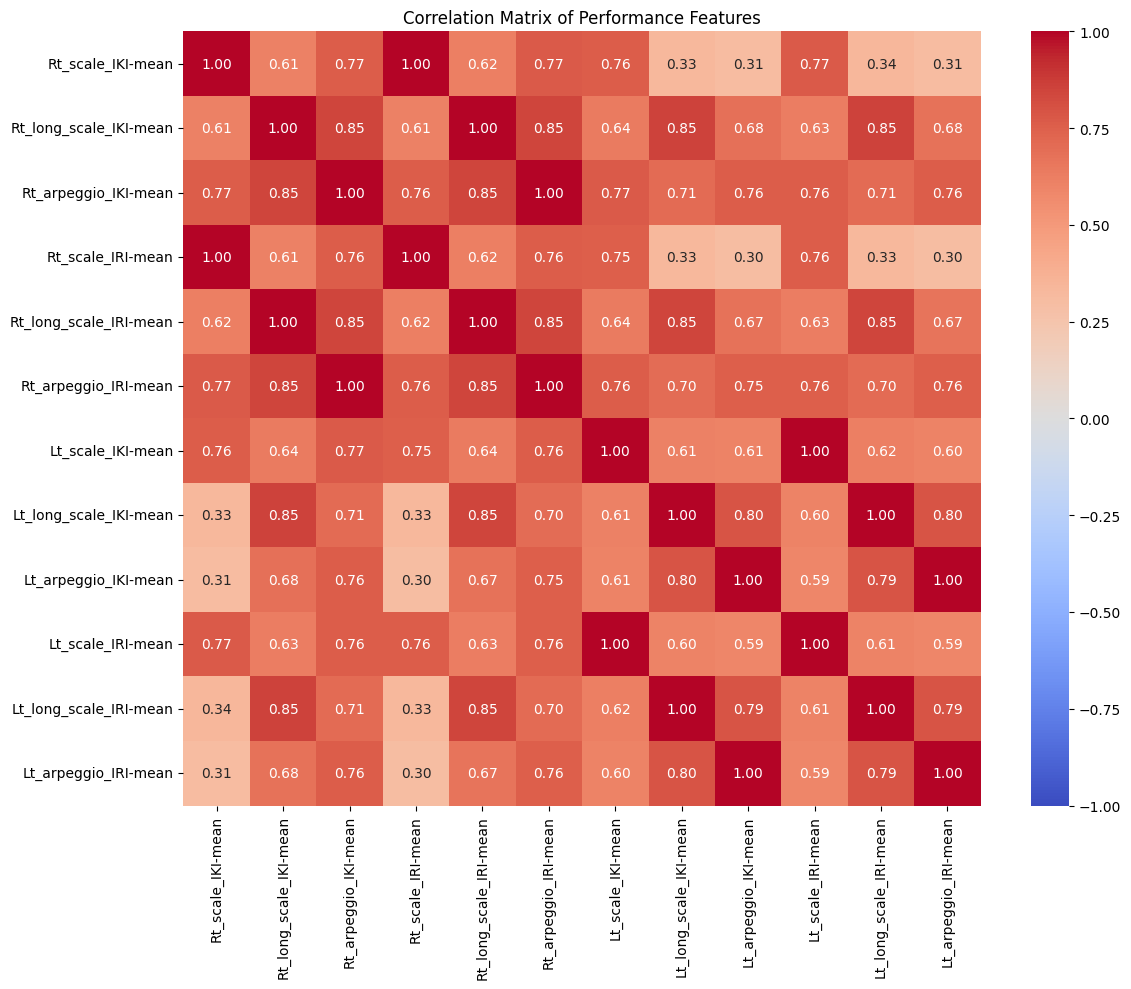

In [17]:
# 相関行列の計算
correlation_matrix = X.corr()

# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # 相関係数を表示
            cmap='coolwarm',  # 色のパレット
            center=0,  # 0を中心とした色付け
            fmt='.2f',  # 小数点2桁まで表示
            vmin=-1, vmax=1)  # スケールの範囲
plt.title('Correlation Matrix of Performance Features')
plt.tight_layout()
plt.show()

In [18]:

# VIF計算
X = df[performance_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を確認（値が大きい順にソート）
print(vif_data.sort_values('VIF', ascending=False))

                   Feature           VIF
11    Lt_arpeggio_IRI-mean  34638.007601
8     Lt_arpeggio_IKI-mean  33561.443742
5     Rt_arpeggio_IRI-mean  20331.275431
2     Rt_arpeggio_IKI-mean  19751.696341
4   Rt_long_scale_IRI-mean  10626.136611
1   Rt_long_scale_IKI-mean  10406.879366
7   Lt_long_scale_IKI-mean   8909.655697
10  Lt_long_scale_IRI-mean   8864.828207
0        Rt_scale_IKI-mean   8260.561555
3        Rt_scale_IRI-mean   8209.686043
9        Lt_scale_IRI-mean   6268.745018
6        Lt_scale_IKI-mean   6249.002407


# 演奏特徴量の分析方針

## 1. 多重共線性の確認と特徴量の整理

### 発見された相関関係
- IKI-meanとIRI-meanに強い相関（r ≈ 1.0）
  - 演奏の速さを反映
  - IKI-meanのみを使用することで冗長性を削減可能
- タスク間の相関
  - long_scaleとarpeggioの間に強い相関 (r ≈ 0.85)
  - scaleは他のタスクとやや弱い相関（r = 0.6-0.7）
- 左右の手の相関は中程度（r = 0.6-0.8）

### IKI-SDとIRI-SDの意味の違い
- **IKI-SD**: 打鍵タイミングのばらつき
  - リズムの安定性を反映
- **IRI-SD**: 離鍵タイミングのばらつき
  - アーティキュレーションのコントロールを反映
  - 演奏家は離鍵を意識的にコントロールしていない可能性

## 2. 分析用の特徴量セット

### 基本特徴量


In [19]:
performance_features = [
# 右手の特徴量
'Rt_scale_IKI-mean', 'Rt_scale_IKI-SD', 'Rt_scale_IRI-SD',
'Rt_long_scale_IKI-mean', 'Rt_long_scale_IKI-SD', 'Rt_long_scale_IRI-SD',
'Rt_arpeggio_IKI-mean', 'Rt_arpeggio_IKI-SD', 'Rt_arpeggio_IRI-SD',
# 左手の特徴量
'Lt_scale_IKI-mean', 'Lt_scale_IKI-SD', 'Lt_scale_IRI-SD',
'Lt_long_scale_IKI-mean', 'Lt_long_scale_IKI-SD', 'Lt_long_scale_IRI-SD',
'Lt_arpeggio_IKI-mean', 'Lt_arpeggio_IKI-SD', 'Lt_arpeggio_IRI-SD'
]

### 派生特徴量の検討
- アーティキュレーションの一貫性指標（IRI-SD/IKI-SD）
- 左右の手の協調性指標
- タスク間の安定性の比較

## 3. 次のステップ
1. 健常者群とジストニア群の比較分析
2. 影響を受けている側（affected side）との関連分析
3. fMRIデータとの統合に向けた特徴量の選定


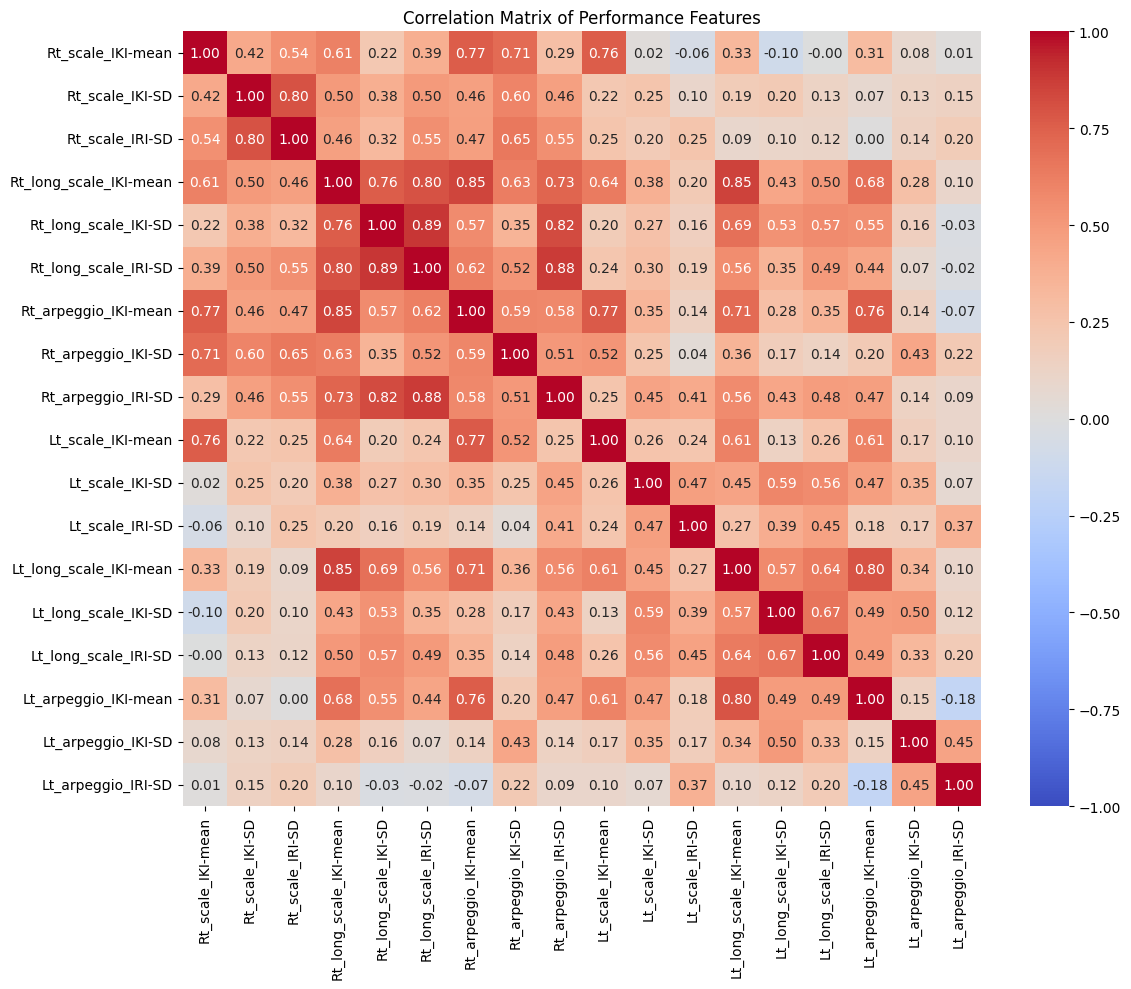

In [20]:
# 新しい特徴量セットでの相関分析

# 相関行列の計算と可視化
correlation_matrix = df[performance_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # 相関係数を表示
            cmap='coolwarm',  # 色のパレット
            center=0,  # 0を中心とした色付け
            fmt='.2f',  # 小数点2桁まで表示
            vmin=-1, vmax=1)  # スケールの範囲
plt.title('Correlation Matrix of Performance Features')
plt.tight_layout()
plt.show()

In [21]:
# VIF計算
X = df[performance_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を確認（値が大きい順にソート）
print(vif_data.sort_values('VIF', ascending=False))

                   Feature         VIF
9        Lt_scale_IKI-mean  175.523940
12  Lt_long_scale_IKI-mean  153.772838
3   Rt_long_scale_IKI-mean  141.094414
6     Rt_arpeggio_IKI-mean  115.289457
0        Rt_scale_IKI-mean   91.455020
15    Lt_arpeggio_IKI-mean   90.585333
5     Rt_long_scale_IRI-SD   81.236014
7       Rt_arpeggio_IKI-SD   71.747439
8       Rt_arpeggio_IRI-SD   67.369646
14    Lt_long_scale_IRI-SD   53.153002
16      Lt_arpeggio_IKI-SD   52.456584
11         Lt_scale_IRI-SD   49.169921
13    Lt_long_scale_IKI-SD   38.192386
2          Rt_scale_IRI-SD   36.485741
10         Lt_scale_IKI-SD   34.577666
4     Rt_long_scale_IKI-SD   34.195203
1          Rt_scale_IKI-SD   33.573900
17      Lt_arpeggio_IRI-SD   24.266709


# 演奏特徴量の分析（改訂版）

## 1. 特徴量の再定義と意味
- IKI-mean: 打鍵間隔の平均（演奏の速さ）
- IKI-SD: 打鍵タイミングのばらつき（リズムの安定性）
- IRI-SD: 離鍵タイミングのばらつき（アーティキュレーションの一貫性）

### リズムとアーティキュレーションの違い
1. **リズム (IKI関連)**
   - 音と音の「間隔」（タイミング）のパターン
   - 例：メトロノームに合わせて等間隔で弾く

2. **アーティキュレーション (IRI関連)**
   - 個々の音の「長さ」や「つなぎ方」
   - 例：スタッカート（短く切る）vs レガート（なめらかにつなぐ）

## 2. 多重共線性の分析結果

### VIF分析の結果
1. **mean値（VIF: 90-175）**
   ```
   Lt_scale_IKI-mean      175.52
   Lt_long_scale_IKI-mean 153.77
   Rt_long_scale_IKI-mean 141.09
   Rt_arpeggio_IKI-mean   115.29
   Rt_scale_IKI-mean       91.46
   Lt_arpeggio_IKI-mean    90.59
   ```

2. **SD値（VIF: 24-81）**
   ```
   Rt_long_scale_IRI-SD    81.24
   Rt_arpeggio_IKI-SD      71.75
   ...
   Lt_arpeggio_IRI-SD      24.27
   ```

### 解釈
1. **mean値の高いVIF**
   - 演奏の「速さ」を反映
   - 同じ人が速く弾くなら全てのタスクで速い傾向
   - → 変数間で情報が重複

2. **SD値の比較的低いVIF**
   - リズム（IKI-SD）とアーティキュレーション（IRI-SD）は異なる側面を測定
   - タスクごとの難しさも異なる
   - → より独立した情報を含む

## 3. 推奨される分析アプローチ
1. mean値は選択的に使用
   - タスクごとに代表的な特徴量を選択
2. SD値は積極的に活用
   - リズムとアーティキュレーションの両面を評価
3. 新しい指標の検討
   - アーティキュレーションの一貫性（IRI-SD/IKI-SD）
   - 左右の手の協調性
   - タスク間の安定性比較

In [22]:
# 基本特徴量の再定義（IKI-meanのみ）
basic_features = [
    # 右手の特徴量
    'Rt_scale_IKI-mean', 'Rt_scale_IKI-SD', 'Rt_scale_IRI-SD',
    'Rt_long_scale_IKI-mean', 'Rt_long_scale_IKI-SD', 'Rt_long_scale_IRI-SD',
    'Rt_arpeggio_IKI-mean', 'Rt_arpeggio_IKI-SD', 'Rt_arpeggio_IRI-SD',
    # 左手の特徴量
    'Lt_scale_IKI-mean', 'Lt_scale_IKI-SD', 'Lt_scale_IRI-SD',
    'Lt_long_scale_IKI-mean', 'Lt_long_scale_IKI-SD', 'Lt_long_scale_IRI-SD',
    'Lt_arpeggio_IKI-mean', 'Lt_arpeggio_IKI-SD', 'Lt_arpeggio_IRI-SD'
]

# 新しい特徴量の作成
def create_derived_features(df):
    derived_features = pd.DataFrame()
    
    # アーティキュレーションの一貫性指標（IRI-SD/IKI-SD）
    tasks = ['scale', 'long_scale', 'arpeggio']
    hands = ['Rt', 'Lt']
    
    for hand in hands:
        for task in tasks:
            col_name = f'{hand}_{task}_articulation_consistency'
            iri_sd = df[f'{hand}_{task}_IRI-SD']
            iki_sd = df[f'{hand}_{task}_IKI-SD']
            derived_features[col_name] = iri_sd / iki_sd
    
    # 左右の手の協調性指標（mean値の差の絶対値）
    for task in tasks:
        col_name = f'{task}_hands_coordination_mean'
        rt_mean = df[f'Rt_{task}_IKI-mean']
        lt_mean = df[f'Lt_{task}_IKI-mean']
        derived_features[col_name] = abs(rt_mean - lt_mean)
        
        # SDの協調性も追加
        col_name = f'{task}_hands_coordination_SD'
        rt_sd = df[f'Rt_{task}_IKI-SD']
        lt_sd = df[f'Lt_{task}_IKI-SD']
        derived_features[col_name] = abs(rt_sd - lt_sd)
    
    return derived_features

# 新しい特徴量の作成
derived_features = create_derived_features(df)

# 基本特徴量と派生特徴量の結合
analysis_df = pd.concat([df[basic_features], derived_features], axis=1)

# 新しい特徴量セットの確認
print("新しい特徴量の一覧:")
print("\nアーティキュレーションの一貫性指標:")
print([col for col in derived_features.columns if 'articulation_consistency' in col])
print("\n左右の手の協調性指標:")
print([col for col in derived_features.columns if 'hands_coordination' in col])

新しい特徴量の一覧:

アーティキュレーションの一貫性指標:
['Rt_scale_articulation_consistency', 'Rt_long_scale_articulation_consistency', 'Rt_arpeggio_articulation_consistency', 'Lt_scale_articulation_consistency', 'Lt_long_scale_articulation_consistency', 'Lt_arpeggio_articulation_consistency']

左右の手の協調性指標:
['scale_hands_coordination_mean', 'scale_hands_coordination_SD', 'long_scale_hands_coordination_mean', 'long_scale_hands_coordination_SD', 'arpeggio_hands_coordination_mean', 'arpeggio_hands_coordination_SD']


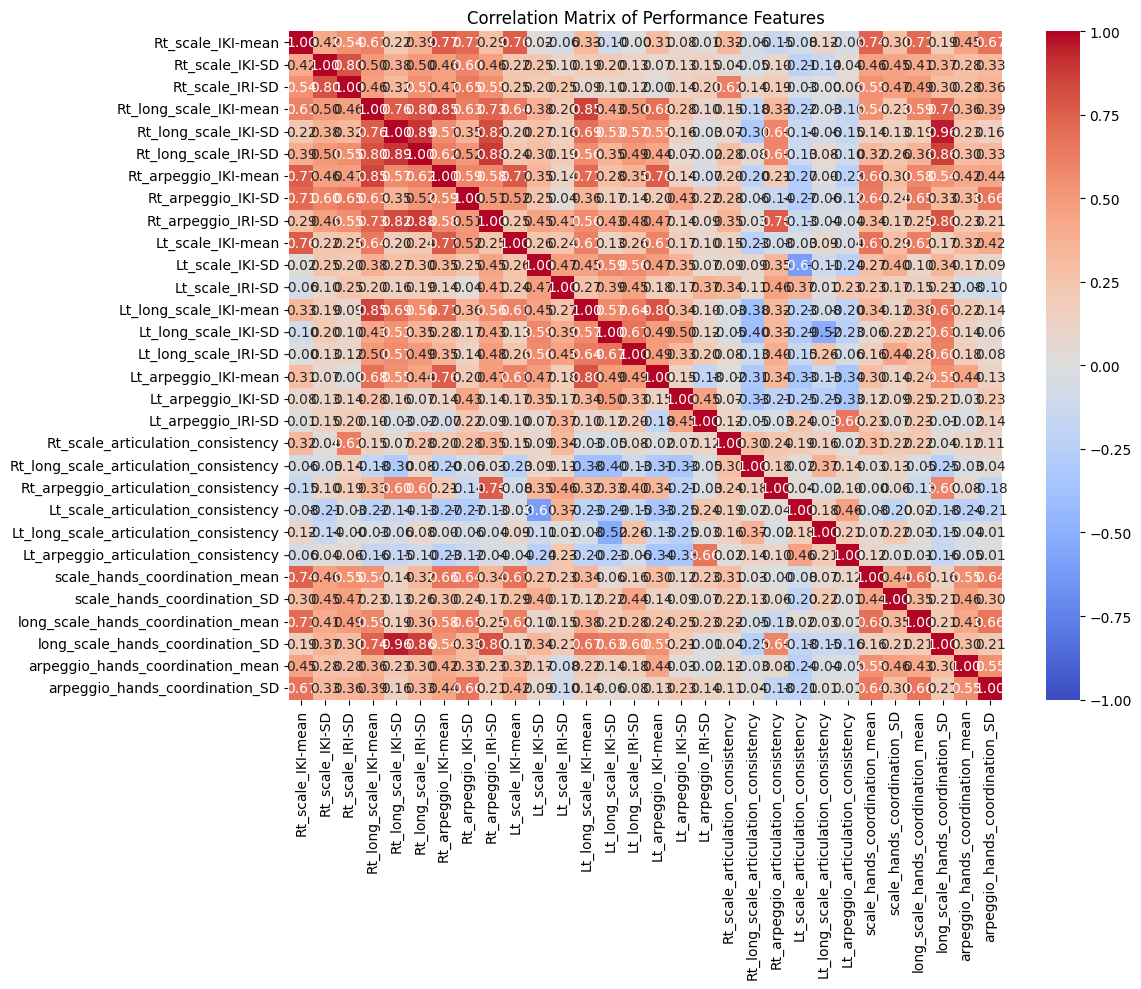


VIF values (sorted):
                                   Feature          VIF
2                          Rt_scale_IRI-SD  1397.595052
1                          Rt_scale_IKI-SD  1360.348415
14                    Lt_long_scale_IRI-SD  1332.699156
15                    Lt_arpeggio_IKI-mean  1231.202985
13                    Lt_long_scale_IKI-SD  1218.991996
18       Rt_scale_articulation_consistency  1121.980168
6                     Rt_arpeggio_IKI-mean  1062.365698
22  Lt_long_scale_articulation_consistency  1024.973744
8                       Rt_arpeggio_IRI-SD   965.948544
7                       Rt_arpeggio_IKI-SD   901.052789
20    Rt_arpeggio_articulation_consistency   824.460000
5                     Rt_long_scale_IRI-SD   811.711534
4                     Rt_long_scale_IKI-SD   655.794039
16                      Lt_arpeggio_IKI-SD   611.702715
17                      Lt_arpeggio_IRI-SD   513.074441
21       Lt_scale_articulation_consistency   501.305959
0                        R

In [23]:
# 相関行列の計算と可視化
correlation_matrix = analysis_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # 相関係数を表示
            cmap='coolwarm',  # 色のパレット
            center=0,  # 0を中心とした色付け
            fmt='.2f',  # 小数点2桁まで表示
            vmin=-1, vmax=1)  # スケールの範囲
plt.title('Correlation Matrix of Performance Features')
plt.tight_layout()
plt.show()

# VIF計算
X = analysis_df
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を確認（値が大きい順にソート）
print("\nVIF values (sorted):")
print(vif_data.sort_values('VIF', ascending=False))

# 演奏特徴量の分析（VIF分析結果）

## 1. VIFの分布パターン

### 非常に高いVIF (>1000)
```
Rt_scale_IRI-SD                      1397.60
Rt_scale_IKI-SD                      1360.35
Lt_long_scale_IRI-SD                 1332.70
Lt_arpeggio_IKI-mean                 1231.20
Lt_long_scale_IKI-SD                 1219.00
Rt_scale_articulation_consistency     1122.00
```

### 中程度のVIF (400-1000)
- 多くの基本特徴量（IKI-mean, IKI-SD, IRI-SD）
- いくつかのアーティキュレーション一貫性指標

### 比較的低いVIF (<50)
```
long_scale_hands_coordination_mean    35.27
scale_hands_coordination_mean         27.73
scale_hands_coordination_SD           11.72
arpeggio_hands_coordination_SD        11.33
```

## 2. 重要な発見

### 手の協調性指標が有望
- 左右の手の協調性を示す指標が最も低いVIF値を示している
- これらの指標は比較的独立した情報を持っている可能性が高い

### アーティキュレーション一貫性の問題
- 予想に反して、アーティキュレーション一貫性指標は高いVIF値を示している
- これは元のSD値との強い相関を示唆

## 3. 推奨される対応策

```python
# より独立性の高い特徴量セットの例
selected_features = [
    # 基本的な速度指標（各タスクから1つ）
    'Rt_scale_IKI-mean',
    'Rt_long_scale_IKI-mean',
    'Rt_arpeggio_IKI-mean',
    
    # 手の協調性指標（VIFが低い）
    'scale_hands_coordination_mean',
    'scale_hands_coordination_SD',
    'long_scale_hands_coordination_mean',
    'arpeggio_hands_coordination_SD',
    
    # 代表的なSD値（選択的に）
    'Rt_scale_IKI-SD',
    'Lt_scale_IRI-SD'
]
```

## 4. 次のステップ
1. 手の協調性指標を中心とした分析の検討
2. アーティキュレーション一貫性指標の再設計の可能性
3. 基本特徴量の更なる選択的使用

こ。